<style>
/* Style pour améliorer la lisibilité et la présentation */
h1 { color: #2E86C1; text-align: center; font-size: 28px; }
h2 { color: #2874A6; font-size: 24px; }
h3 { color: #1B4F72; font-size: 20px; }
h4 { color: #154360; font-size: 18px; }
p, li { font-size: 16px; }
strong { color: #D35400; }
</style>



# Introduction à l’analyse des données géospatiales appliquée au contexte agricole
# Etude spatio-temporelle de l'indice NDVI et SPI au region Beni-mellal khenifra

---
************************************************************************************************************************************************************
#### Réalisé par : **Adam Daoudi** | Eleve ingenieur en Data Science à l'INSEA 
# Année académique : 2024-2025

---

************************************************************************************************************************************************************
## Introduction
ce projet vise à:
+ **analyser et combiner les indices SPI (précipitations) et NDVI (santé de la végétation) avec des méthodes de machine learning pour détecter, caractériser et prédire les épisodes de sécheresse dans le région de Béni-mellal Khenifra.**
+ **Ce travail s’inscrit dans le cadre de la surveillance de la sécheresse agricole, en combinant l’analyse des déficits pluviométriques (SPI) et la réponse de la végétation (NDVI) à l’échelle mensuelle**

---

## *Problematique* :  **Comment combiner les indices SPI (précipitations) et NDVI (santé de la végétation) avec des méthodes de machine learning pour détecter, caractériser et prédire les épisodes de sécheresse dans le region de Béni-mellal Khénifra ?**

## Méthodologie

### A. Collecte et prétraitement des données géospatiales (ex :MODIS, CHIRPS)
- Téléchargement des données satellites MODIS et précipitations CHIRPS.
- Extraction des variables pertinentes.
- Nettoyage, reprojection et découpage des rasters (zones d’étude proposée :Béni Mellal-Khénifra).


### B. Analyse exploratoire et visualisation cartographique
- Visualisation des cartes NDVI et SPI.
- Etude temporelle (évolution mensuelle/annuelle).
- Corrélations entre indices.


### C. Modélisation statistique ou machine learning
- Développement de modèles de d'etection ou de prédiction de sécheresse.
- Application de modèles statistiques ou machine learning.
- Analyse des résultats et validation.



## A. Preparation des Données NDVI et SPI


### Importation des bibliotheque necessaires 

In [1]:
import os
import urllib.request
import time
from datetime import datetime, timedelta
import gzip
import shutil
import geopandas as gpd 
from osgeo import gdal
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio import open as rio_open
from pymodis import downmodis
import glob
from bs4 import BeautifulSoup
import pandas as pd 
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt 
import earthaccess 
from pathlib import Path
import logging

import warnings
warnings.filterwarnings("ignore")

### Chirps dataset (SPI index)

In [ ]:


base_url = "https://data.chc.ucsb.edu/products/CHIRPS-2.0/africa_monthly/tifs/"
output_dir = "chirps_data"
os.makedirs(output_dir, exist_ok=True)

# Générer la liste des dates de 1981 à mai 2025
dates = pd.date_range(start="1981-01", end="2025-05", freq="MS")
formatted_dates = [date.strftime("%Y.%m") for date in dates]

for date in formatted_dates:
    filename = f'chirps-v2.0.{date}.tif.gz'
    url = base_url + filename
    filepath = os.path.join(output_dir, filename)

    if os.path.exists(filepath):
        print(f"{filename} déjà présent, on passe.")
        continue

    print(f"⬇Téléchargement de {filename}...")


    max_retries = 3
    for attempt in range(max_retries):
        try:
            urllib.request.urlretrieve(url, filepath)
            print(f"Téléchargé : {filename}")
            break
        except Exception as e:
            print(f"Tentative {attempt + 1} échouée : {e}")
            if attempt < max_retries - 1:
                print("Nouvelle tentative dans 2 secondes...")
                time.sleep(2)
            else:
                print(f"Échec du téléchargement de {filename} après {max_retries} tentatives.")


⬇️ Téléchargement de chirps-v2.0.1981.01.tif.gz...
✅ Téléchargé : chirps-v2.0.1981.01.tif.gz
⬇️ Téléchargement de chirps-v2.0.1981.02.tif.gz...
✅ Téléchargé : chirps-v2.0.1981.02.tif.gz
⬇️ Téléchargement de chirps-v2.0.1981.03.tif.gz...
✅ Téléchargé : chirps-v2.0.1981.03.tif.gz
⬇️ Téléchargement de chirps-v2.0.1981.04.tif.gz...
✅ Téléchargé : chirps-v2.0.1981.04.tif.gz
⬇️ Téléchargement de chirps-v2.0.1981.05.tif.gz...
✅ Téléchargé : chirps-v2.0.1981.05.tif.gz
⬇️ Téléchargement de chirps-v2.0.1981.06.tif.gz...
✅ Téléchargé : chirps-v2.0.1981.06.tif.gz
⬇️ Téléchargement de chirps-v2.0.1981.07.tif.gz...
✅ Téléchargé : chirps-v2.0.1981.07.tif.gz
⬇️ Téléchargement de chirps-v2.0.1981.08.tif.gz...
✅ Téléchargé : chirps-v2.0.1981.08.tif.gz
⬇️ Téléchargement de chirps-v2.0.1981.09.tif.gz...
✅ Téléchargé : chirps-v2.0.1981.09.tif.gz
⬇️ Téléchargement de chirps-v2.0.1981.10.tif.gz...
✅ Téléchargé : chirps-v2.0.1981.10.tif.gz
⬇️ Téléchargement de chirps-v2.0.1981.11.tif.gz...
✅ Téléchargé : chir

#### decompression

In [ ]:

input_dir = "chirps_data"
output_dir = "chirps_tif's"
os.makedirs(output_dir, exist_ok=True)


for filename in os.listdir(input_dir):
    if filename.endswith(".tif.gz"):
        gz_path = os.path.join(input_dir, filename)
        tif_filename = filename[:-3]  # remove ".gz"
        tif_path = os.path.join(output_dir, tif_filename)

        # Skip if .tif already exists
        if os.path.exists(tif_path):
            print(f"{tif_filename} déjà extrait.")
            continue

        #Décompression
        try:
            with gzip.open(gz_path, 'rb') as f_in, open(tif_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
            print(f"Décompressé : {tif_filename}")
        except Exception as e:
            print(f"Erreur avec {filename} : {e}")


📂 Décompressé : chirps-v2.0.1981.01.tif
📂 Décompressé : chirps-v2.0.1981.02.tif
📂 Décompressé : chirps-v2.0.1981.03.tif
📂 Décompressé : chirps-v2.0.1981.04.tif
📂 Décompressé : chirps-v2.0.1981.05.tif
📂 Décompressé : chirps-v2.0.1981.06.tif
📂 Décompressé : chirps-v2.0.1981.07.tif
📂 Décompressé : chirps-v2.0.1981.08.tif
📂 Décompressé : chirps-v2.0.1981.09.tif
📂 Décompressé : chirps-v2.0.1981.10.tif
📂 Décompressé : chirps-v2.0.1981.11.tif
📂 Décompressé : chirps-v2.0.1981.12.tif
📂 Décompressé : chirps-v2.0.1982.01.tif
📂 Décompressé : chirps-v2.0.1982.02.tif
📂 Décompressé : chirps-v2.0.1982.03.tif
📂 Décompressé : chirps-v2.0.1982.04.tif
📂 Décompressé : chirps-v2.0.1982.05.tif
📂 Décompressé : chirps-v2.0.1982.06.tif
📂 Décompressé : chirps-v2.0.1982.07.tif
📂 Décompressé : chirps-v2.0.1982.08.tif
📂 Décompressé : chirps-v2.0.1982.09.tif
📂 Décompressé : chirps-v2.0.1982.10.tif
📂 Décompressé : chirps-v2.0.1982.11.tif
📂 Décompressé : chirps-v2.0.1982.12.tif
📂 Décompressé : chirps-v2.0.1983.01.tif


#### decoupage

In [ ]:
import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd

input_folder = "chirps_tif's"  # Dossier contenant les fichiers .tif
output_folder = "chirps_beni_mellal"
os.makedirs(output_folder, exist_ok=True)

# Charger le fichier geojson ou shapefile de Beni Mellal-Khénifra
gdf = gpd.read_file("beni_mellal_khenifra.geojson")  # ou .shp

# Parcourir les fichiers .tif et les découper
for filename in sorted(os.listdir(input_folder)):
    if filename.endswith(".tif"):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        with rasterio.open(input_path) as src:
            # Appliquer le masque géographique
            out_image, out_transform = mask(src, gdf.geometry, crop=True)
            out_meta = src.meta.copy()

            # Mettre à jour les métadonnées
            out_meta.update({
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })

            # Enregistrer le fichier découpé
            with rasterio.open(output_path, "w", **out_meta) as dest:
                dest.write(out_image)

        print(f"Découpé : {filename}")


✅ Découpé : chirps-v2.0.1981.01.tif
✅ Découpé : chirps-v2.0.1981.02.tif
✅ Découpé : chirps-v2.0.1981.03.tif
✅ Découpé : chirps-v2.0.1981.04.tif
✅ Découpé : chirps-v2.0.1981.05.tif
✅ Découpé : chirps-v2.0.1981.06.tif
✅ Découpé : chirps-v2.0.1981.07.tif
✅ Découpé : chirps-v2.0.1981.08.tif
✅ Découpé : chirps-v2.0.1981.09.tif
✅ Découpé : chirps-v2.0.1981.10.tif
✅ Découpé : chirps-v2.0.1981.11.tif
✅ Découpé : chirps-v2.0.1981.12.tif
✅ Découpé : chirps-v2.0.1982.01.tif
✅ Découpé : chirps-v2.0.1982.02.tif
✅ Découpé : chirps-v2.0.1982.03.tif
✅ Découpé : chirps-v2.0.1982.04.tif
✅ Découpé : chirps-v2.0.1982.05.tif
✅ Découpé : chirps-v2.0.1982.06.tif
✅ Découpé : chirps-v2.0.1982.07.tif
✅ Découpé : chirps-v2.0.1982.08.tif
✅ Découpé : chirps-v2.0.1982.09.tif
✅ Découpé : chirps-v2.0.1982.10.tif
✅ Découpé : chirps-v2.0.1982.11.tif
✅ Découpé : chirps-v2.0.1982.12.tif
✅ Découpé : chirps-v2.0.1983.01.tif
✅ Découpé : chirps-v2.0.1983.02.tif
✅ Découpé : chirps-v2.0.1983.03.tif
✅ Découpé : chirps-v2.0.1983

chirps-v2.0.1981.01.tif : 20.13 mm
chirps-v2.0.1981.02.tif : 25.83 mm
chirps-v2.0.1981.03.tif : 21.94 mm
chirps-v2.0.1981.04.tif : 25.70 mm
chirps-v2.0.1981.05.tif : 10.76 mm
chirps-v2.0.1981.06.tif : 7.18 mm
chirps-v2.0.1981.07.tif : 1.42 mm
chirps-v2.0.1981.08.tif : 3.47 mm
chirps-v2.0.1981.09.tif : 4.17 mm
chirps-v2.0.1981.10.tif : 12.79 mm
chirps-v2.0.1981.11.tif : 20.13 mm
chirps-v2.0.1981.12.tif : 37.41 mm
chirps-v2.0.1982.01.tif : 34.19 mm
chirps-v2.0.1982.02.tif : 37.47 mm
chirps-v2.0.1982.03.tif : 46.43 mm
chirps-v2.0.1982.04.tif : 52.41 mm
chirps-v2.0.1982.05.tif : 34.41 mm
chirps-v2.0.1982.06.tif : 4.80 mm
chirps-v2.0.1982.07.tif : 1.71 mm
chirps-v2.0.1982.08.tif : 3.46 mm
chirps-v2.0.1982.09.tif : 4.88 mm
chirps-v2.0.1982.10.tif : 15.03 mm
chirps-v2.0.1982.11.tif : 21.64 mm
chirps-v2.0.1982.12.tif : 25.56 mm
chirps-v2.0.1983.01.tif : 12.30 mm
chirps-v2.0.1983.02.tif : 29.90 mm
chirps-v2.0.1983.03.tif : 28.40 mm
chirps-v2.0.1983.04.tif : 20.91 mm
chirps-v2.0.1983.05.tif : 18

chirps-v2.0.1981.01.tif : SPI = -0.08
chirps-v2.0.1981.02.tif : SPI = 0.23
chirps-v2.0.1981.03.tif : SPI = 0.02
chirps-v2.0.1981.04.tif : SPI = 0.23
chirps-v2.0.1981.05.tif : SPI = -0.59
chirps-v2.0.1981.06.tif : SPI = -0.79
chirps-v2.0.1981.07.tif : SPI = -1.10
chirps-v2.0.1981.08.tif : SPI = -0.99
chirps-v2.0.1981.09.tif : SPI = -0.95
chirps-v2.0.1981.10.tif : SPI = -0.48
chirps-v2.0.1981.11.tif : SPI = -0.08
chirps-v2.0.1981.12.tif : SPI = 0.87
chirps-v2.0.1982.01.tif : SPI = 0.69
chirps-v2.0.1982.02.tif : SPI = 0.87
chirps-v2.0.1982.03.tif : SPI = 1.36
chirps-v2.0.1982.04.tif : SPI = 1.69
chirps-v2.0.1982.05.tif : SPI = 0.70
chirps-v2.0.1982.06.tif : SPI = -0.92
chirps-v2.0.1982.07.tif : SPI = -1.09
chirps-v2.0.1982.08.tif : SPI = -0.99
chirps-v2.0.1982.09.tif : SPI = -0.91
chirps-v2.0.1982.10.tif : SPI = -0.36
chirps-v2.0.1982.11.tif : SPI = 0.00
chirps-v2.0.1982.12.tif : SPI = 0.22
chirps-v2.0.1983.01.tif : SPI = -0.51
chirps-v2.0.1983.02.tif : SPI = 0.45
chirps-v2.0.1983.03.tif 

### MODIS dataset (NDVI index)

In [36]:
output_dir= "C:\\Users\\CE PC\\Desktop\\Drought monitoring\\ndvi_data"
url = 'http://www.cgms-maroc.ma/ndvi/'

In [37]:
date_debut=datetime(2000, 1, 1)
date_actuelle= datetime.now()

In [38]:
os.makedirs(output_dir, exist_ok=True)

In [39]:
reqs= requests.get(url)
soup= BeautifulSoup(reqs.text, 'html.parser')


In [40]:
folders = [link['href'] for link in soup.find_all('a') if link['href'].endswith("/")]
folders

['/',
 '2000.02.18/',
 '2000.03.05/',
 '2000.03.21/',
 '2000.04.06/',
 '2000.04.22/',
 '2000.05.08/',
 '2000.05.24/',
 '2000.06.09/',
 '2000.06.25/',
 '2000.07.11/',
 '2000.07.27/',
 '2000.08.12/',
 '2000.08.28/',
 '2000.09.13/',
 '2000.09.29/',
 '2000.10.15/',
 '2000.10.31/',
 '2000.11.16/',
 '2000.12.02/',
 '2000.12.18/',
 '2001.01.01/',
 '2001.01.17/',
 '2001.02.02/',
 '2001.02.18/',
 '2001.03.06/',
 '2001.03.22/',
 '2001.04.07/',
 '2001.04.23/',
 '2001.05.09/',
 '2001.05.25/',
 '2001.06.10/',
 '2001.06.26/',
 '2001.07.12/',
 '2001.07.28/',
 '2001.08.13/',
 '2001.08.29/',
 '2001.09.14/',
 '2001.09.30/',
 '2001.10.16/',
 '2001.11.01/',
 '2001.11.17/',
 '2001.12.03/',
 '2001.12.19/',
 '2002.01.01/',
 '2002.01.17/',
 '2002.02.02/',
 '2002.02.18/',
 '2002.03.06/',
 '2002.03.22/',
 '2002.04.07/',
 '2002.04.23/',
 '2002.05.09/',
 '2002.05.25/',
 '2002.06.10/',
 '2002.06.26/',
 '2002.07.04/',
 '2002.07.12/',
 '2002.07.20/',
 '2002.07.28/',
 '2002.08.05/',
 '2002.08.13/',
 '2002.08.21/',
 '

In [41]:
ndvi_links=[]

In [ ]:
import re

ndvi_links = []

pattern = re.compile(r"^ndvi(\d{4}\.\d{2}\.\d{2})\.tiff$", re.IGNORECASE)

for folder in folders:
    folder_url = url + folder
    reqs_folder = requests.get(folder_url)
    soup_folder = BeautifulSoup(reqs_folder.text, 'html.parser')

    for link in soup_folder.find_all('a'):
        file_name = link['href']
        match = pattern.match(file_name)
        if match:

            ndvi_links.append(folder_url + file_name)

print(ndvi_links)  # Liste des liens NDVI au bon format

['http://www.cgms-maroc.ma/ndvi/2000.02.18/ndvi2000.02.18.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.03.05/ndvi2000.03.05.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.03.21/ndvi2000.03.21.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.04.06/ndvi2000.04.06.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.04.22/ndvi2000.04.22.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.05.08/ndvi2000.05.08.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.05.24/ndvi2000.05.24.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.06.09/ndvi2000.06.09.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.06.25/ndvi2000.06.25.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.07.11/ndvi2000.07.11.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.07.27/ndvi2000.07.27.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.08.12/ndvi2000.08.12.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.08.28/ndvi2000.08.28.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.09.13/ndvi2000.09.13.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.09.29/ndvi2000.09.29.tiff', 'http://www.cgms-maroc.ma/ndvi/2000.10.

In [51]:
if not ndvi_links:
    print("Aucun fichier ndvi trouvé depuis le 18/02/2000.")
else:
    print(f"{len(ndvi_links)} fichiers NDVI trouvés.")

1107 fichiers NDVI trouvés.


In [52]:
import os
import requests

for link in ndvi_links:
    file_name = link.split('/')[-1]
    print(f"Téléchargement du fichier : {file_name}")

    try:
        r = requests.get(link, stream=True, timeout=30)
        r.raise_for_status()
        with open(os.path.join(output_dir, file_name), 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)
        print(f"{file_name} téléchargé !\n")
    except Exception as e:
        print(f"Erreur lors du téléchargement de {file_name} : {e}")

print("Tous les fichiers NDVI ont été téléchargés !")

Téléchargement du fichier : ndvi2000.02.18.tiff
ndvi2000.02.18.tiff téléchargé !

Téléchargement du fichier : ndvi2000.03.05.tiff
ndvi2000.03.05.tiff téléchargé !

Téléchargement du fichier : ndvi2000.03.21.tiff
ndvi2000.03.21.tiff téléchargé !

Téléchargement du fichier : ndvi2000.04.06.tiff
ndvi2000.04.06.tiff téléchargé !

Téléchargement du fichier : ndvi2000.04.22.tiff
ndvi2000.04.22.tiff téléchargé !

Téléchargement du fichier : ndvi2000.05.08.tiff
ndvi2000.05.08.tiff téléchargé !

Téléchargement du fichier : ndvi2000.05.24.tiff
ndvi2000.05.24.tiff téléchargé !

Téléchargement du fichier : ndvi2000.06.09.tiff
ndvi2000.06.09.tiff téléchargé !

Téléchargement du fichier : ndvi2000.06.25.tiff
ndvi2000.06.25.tiff téléchargé !

Téléchargement du fichier : ndvi2000.07.11.tiff
ndvi2000.07.11.tiff téléchargé !

Téléchargement du fichier : ndvi2000.07.27.tiff
ndvi2000.07.27.tiff téléchargé !

Téléchargement du fichier : ndvi2000.08.12.tiff
ndvi2000.08.12.tiff téléchargé !

Téléchargement d

In [62]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [63]:
src.crs

CRS.from_wkt('PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [ ]:

input_folder = "ndvi_data"
output_folder = "ndvi_beni_mellal"
os.makedirs(output_folder, exist_ok=True)

# Charger geojson de la région
gdf=gdf.to_crs(src.crs)
gdf = gpd.read_file("beni_mellal_khenifra.geojson") 

for filename in sorted(os.listdir(input_folder)):
    if filename.endswith(".tiff"):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        with rasterio.open(input_path) as src:

            if gdf.crs != src.crs:
                gdf = gdf.to_crs(src.crs)
            out_image, out_transform = mask(src, gdf.geometry, crop=True)

            out_meta = src.meta.copy()
            out_meta.update({
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })

            with rasterio.open(output_path, "w", **out_meta) as dest:
                dest.write(out_image)

        print(f"Découpé : {filename}")

✅ Découpé : ndvi2000.02.18.tiff
✅ Découpé : ndvi2000.03.05.tiff
✅ Découpé : ndvi2000.03.21.tiff
✅ Découpé : ndvi2000.04.06.tiff
✅ Découpé : ndvi2000.04.22.tiff
✅ Découpé : ndvi2000.05.08.tiff
✅ Découpé : ndvi2000.05.24.tiff
✅ Découpé : ndvi2000.06.09.tiff
✅ Découpé : ndvi2000.06.25.tiff
✅ Découpé : ndvi2000.07.11.tiff
✅ Découpé : ndvi2000.07.27.tiff
✅ Découpé : ndvi2000.08.12.tiff
✅ Découpé : ndvi2000.08.28.tiff
✅ Découpé : ndvi2000.09.13.tiff
✅ Découpé : ndvi2000.09.29.tiff
✅ Découpé : ndvi2000.10.15.tiff
✅ Découpé : ndvi2000.10.31.tiff
✅ Découpé : ndvi2000.11.16.tiff
✅ Découpé : ndvi2000.12.02.tiff
✅ Découpé : ndvi2000.12.18.tiff
✅ Découpé : ndvi2001.01.01.tiff
✅ Découpé : ndvi2001.01.17.tiff
✅ Découpé : ndvi2001.02.02.tiff
✅ Découpé : ndvi2001.02.18.tiff
✅ Découpé : ndvi2001.03.06.tiff
✅ Découpé : ndvi2001.03.22.tiff
✅ Découpé : ndvi2001.04.07.tiff
✅ Découpé : ndvi2001.04.23.tiff
✅ Découpé : ndvi2001.05.09.tiff
✅ Découpé : ndvi2001.05.25.tiff
✅ Découpé : ndvi2001.06.10.tiff
✅ Découp

## B. Analyse exloratoire(EDA)

In [50]:
input_folder = "chirps_beni_mellal"  # ou "ndvi_tifs"
shapefile_path = "beni_mellal_khenifra.geojson"
index_type = "SPI"  # ou "NDVI"


In [51]:
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs("EPSG:4326")


In [52]:
files = sorted([f for f in os.listdir(input_folder) if f.endswith(".tif")])


In [53]:
import rasterio
import numpy as np

for file in files:
    file_path = os.path.join(input_folder, file)
    with rasterio.open(file_path) as src:
        arr = src.read(1)
        print(f"{file}: unique values = {np.unique(arr)}")

chirps-v2.0.1981.01.tif: unique values = [  0.         14.025794   15.4848385 ... 100.52024   101.883965
 102.2128   ]
chirps-v2.0.1981.02.tif: unique values = [  0.       19.58178  19.5965  ... 127.64856 128.23932 154.3376 ]
chirps-v2.0.1981.03.tif: unique values = [  0.        22.637348  22.766851 ... 131.24352  131.89517  139.95181 ]
chirps-v2.0.1981.04.tif: unique values = [ 0.       20.196083 20.301556 ... 86.788    94.33647  97.18523 ]
chirps-v2.0.1981.05.tif: unique values = [ 0.         9.359943   9.5797615 ... 30.626661  31.53888   31.945202 ]
chirps-v2.0.1981.06.tif: unique values = [ 0.         4.4457946  4.5024986 ... 19.940372  20.169357  20.28842  ]
chirps-v2.0.1981.07.tif: unique values = [0.         0.51733935 0.5659056  ... 4.335635   4.3579755  4.443166  ]
chirps-v2.0.1981.08.tif: unique values = [ 0.          0.90217793  1.0350854  ... 11.50556    11.869806
 12.724937  ]
chirps-v2.0.1981.09.tif: unique values = [ 0.         2.513978   2.5743957 ... 14.422108  14.5065

In [67]:
results = []

for file in files:
    file_path = os.path.join(input_folder, file)
    print(f"Traitement du fichier : {file_path}")

    with rasterio.open(file_path) as src:
        out_image, out_transform = mask(src, gdf.geometry, crop=True)
        out_data = out_image[0]


Traitement du fichier : chirps_beni_mellal\chirps-v2.0.1981.01.tif
Traitement du fichier : chirps_beni_mellal\chirps-v2.0.1981.02.tif
Traitement du fichier : chirps_beni_mellal\chirps-v2.0.1981.03.tif
Traitement du fichier : chirps_beni_mellal\chirps-v2.0.1981.04.tif
Traitement du fichier : chirps_beni_mellal\chirps-v2.0.1981.05.tif
Traitement du fichier : chirps_beni_mellal\chirps-v2.0.1981.06.tif
Traitement du fichier : chirps_beni_mellal\chirps-v2.0.1981.07.tif
Traitement du fichier : chirps_beni_mellal\chirps-v2.0.1981.08.tif
Traitement du fichier : chirps_beni_mellal\chirps-v2.0.1981.09.tif
Traitement du fichier : chirps_beni_mellal\chirps-v2.0.1981.10.tif
Traitement du fichier : chirps_beni_mellal\chirps-v2.0.1981.11.tif
Traitement du fichier : chirps_beni_mellal\chirps-v2.0.1981.12.tif
Traitement du fichier : chirps_beni_mellal\chirps-v2.0.1982.01.tif
Traitement du fichier : chirps_beni_mellal\chirps-v2.0.1982.02.tif
Traitement du fichier : chirps_beni_mellal\chirps-v2.0.1982.03

In [72]:
out_data = np.where((out_data == src.nodata) | np.isnan(out_data), np.nan, out_data)

if index_type.upper() == "NDVI":
    out_data = out_data.astype(float) * 0.0001
    out_data = np.where((out_data < -0.2) | (out_data > 1.0), np.nan, out_data)

print(f"Valeurs uniques pour {file}: {np.unique(out_data)}")

Valeurs uniques pour chirps-v2.0.2025.05.tif: [ 0.         6.881752   7.3123918 ... 43.78756   44.115135  45.02182  ]


In [70]:
mean_value = np.nanmean(out_data)
print(mean_value)

13.150287


In [86]:

input_folder = "chirps_beni_mellal"
index_type = "SPI"
results = []

files = sorted([f for f in os.listdir(input_folder) if f.endswith(".tif")])

for file in files:
    file_path = os.path.join(input_folder, file)
    with rasterio.open(file_path) as src:
        data = src.read(1)
        data = np.where((data == src.nodata) | np.isnan(data), np.nan, data)

        # Appliquer le facteur d'échelle si besoin (exemple pour SPI)
        data = data.astype(float) * 0.0001
        #data = np.where((data < -10) | (data > 10), np.nan, data)
        mean_value = np.nanmean(data)
    match = re.search(r'(\d{4}\.\d{2})', file)
    if match:
        date_str = match.group(1)
        results.append({"date": date_str, f"mean_{index_type.lower()}": mean_value})
    else:
        print(f"Date not found in filename: {file}")

# Création du DataFrame et sauvegarde CSV
df = pd.DataFrame(results)
df["date"] = pd.to_datetime(df["date"], format="%Y.%m")
df = df.sort_values("date")
output_csv = f"mean_{index_type.lower()}_bmk.csv"
df.to_csv(output_csv, index=False)
print(f"Moyennes mensuelles enregistrées dans : {output_csv}")

Moyennes mensuelles enregistrées dans : mean_spi_bmk.csv


In [92]:
import os
import re
import rasterio
import numpy as np
import pandas as pd

input_folder = "ndvi_beni_mellal"
index_type = "NDVI"
results = []

files = sorted([f for f in os.listdir(input_folder) if f.endswith(".tiff")])

for file in files:
    path = os.path.join(input_folder, file)
    with rasterio.open(path) as src:
        data = src.read(1).astype(float) * 0.0001  # Apply scale factor

        # Mask out invalid NDVI values
        data = np.where((data < -0.2) | (data > 1.0), np.nan, data)

        mean_value = np.nanmean(data)

    # Extract date from filename like ndvi2000.02.18.tiff
    match = re.search(r'(\d{4}\.\d{2}\.\d{2})', file)
    if match:
        date_str = match.group(1)
        results.append({"date": date_str, f"mean_{index_type.lower()}": mean_value})
    else:
        print(f'Date not found in filename: {file}')
        continue

# Create dataframe
df = pd.DataFrame(results)
df["date"] = pd.to_datetime(df["date"], format="%Y.%m.%d")
df = df.sort_values("date")

# Save to CSV
output_csv = f"mean_{index_type.lower()}_bmk.csv"
df.to_csv(output_csv, index=False)
print(f"Moyennes mensuelles enregistrées dans : {output_csv}")


Moyennes mensuelles enregistrées dans : mean_ndvi_bmk.csv


In [93]:
mean_ndvi_bmk= pd.read_csv("mean_ndvi_bmk.csv")
mean_spi_bmk = pd.read_csv("mean_spi_bmk.csv")

In [96]:
print(mean_spi_bmk.head())
print('\n')
print(mean_ndvi_bmk.head())

         date  mean_spi
0  1981-01-01  0.002013
1  1981-02-01  0.002583
2  1981-03-01  0.002194
3  1981-04-01  0.002570
4  1981-05-01  0.001076


         date  mean_ndvi
0  2000-02-18   0.337062
1  2000-03-05   0.313214
2  2000-03-21   0.296915
3  2000-04-06   0.300845
4  2000-04-22   0.290360


In [102]:
mean_ndvi_bmk['mean_ndvi']= mean_ndvi_bmk['mean_ndvi'].dropna()

<Axes: xlabel='date'>

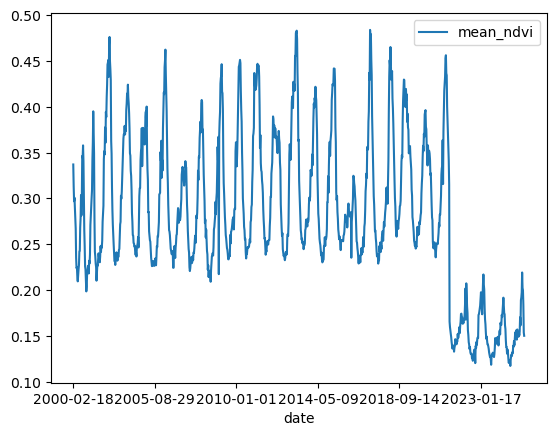

In [103]:
mean_ndvi_bmk.plot(x="date", y="mean_ndvi")


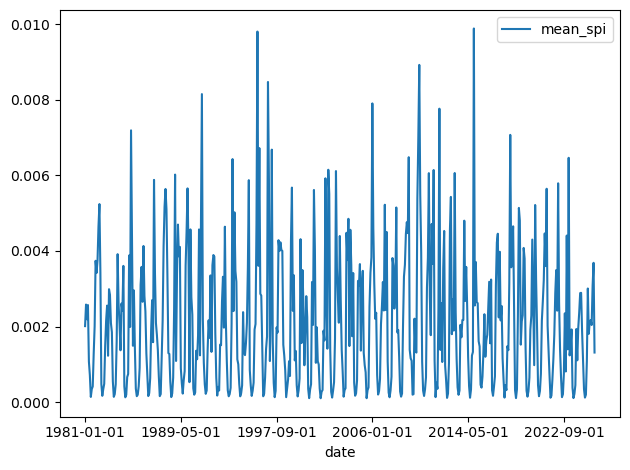

In [109]:
mean_spi_bmk.plot(x='date', y='mean_spi')
plt.tight_layout()
plt.show()

In [59]:
df = pd.DataFrame(results)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")
print(df)

          date   mean_spi
0   1981-01-01  13.150287
1   1981-02-01  13.150287
2   1981-03-01  13.150287
3   1981-04-01  13.150287
4   1981-05-01  13.150287
..         ...        ...
528 2025-01-01  13.150287
529 2025-02-01  13.150287
530 2025-03-01  13.150287
531 2025-04-01  13.150287
532 2025-05-01  13.150287

[533 rows x 2 columns]


In [49]:
df.to_csv(f"mean_{index_type.lower()}_bmk.csv", index=False)
print(f" Moyennes mensuelles enregistrées : mean_{index_type.lower()}_bmk.csv")


 Moyennes mensuelles enregistrées : mean_spi_bmk.csv


In [45]:

folder = "chirps_beni_mellal"  # Dossier contenant les fichiers .tif
mean_values = []

for filename in sorted(os.listdir(folder)):
    if filename.endswith(".tif"):
        path = os.path.join(folder, filename)
        with rasterio.open(path) as src:
            data = src.read(1)
            data[data == src.nodata] = np.nan  # ignorer les pixels vides
            mean = np.nanmean(data)
            mean_values.append((filename, mean))

# Affichage des moyennes
for name, val in mean_values:
    print(f"{name} : {val:.2f} mm")


chirps-v2.0.1981.01.tif : 20.13 mm
chirps-v2.0.1981.02.tif : 25.83 mm
chirps-v2.0.1981.03.tif : 21.94 mm
chirps-v2.0.1981.04.tif : 25.70 mm
chirps-v2.0.1981.05.tif : 10.76 mm
chirps-v2.0.1981.06.tif : 7.18 mm
chirps-v2.0.1981.07.tif : 1.42 mm
chirps-v2.0.1981.08.tif : 3.47 mm
chirps-v2.0.1981.09.tif : 4.17 mm
chirps-v2.0.1981.10.tif : 12.79 mm
chirps-v2.0.1981.11.tif : 20.13 mm
chirps-v2.0.1981.12.tif : 37.41 mm
chirps-v2.0.1982.01.tif : 34.19 mm
chirps-v2.0.1982.02.tif : 37.47 mm
chirps-v2.0.1982.03.tif : 46.43 mm
chirps-v2.0.1982.04.tif : 52.41 mm
chirps-v2.0.1982.05.tif : 34.41 mm
chirps-v2.0.1982.06.tif : 4.80 mm
chirps-v2.0.1982.07.tif : 1.71 mm
chirps-v2.0.1982.08.tif : 3.46 mm
chirps-v2.0.1982.09.tif : 4.88 mm
chirps-v2.0.1982.10.tif : 15.03 mm
chirps-v2.0.1982.11.tif : 21.64 mm
chirps-v2.0.1982.12.tif : 25.56 mm
chirps-v2.0.1983.01.tif : 12.30 mm
chirps-v2.0.1983.02.tif : 29.90 mm
chirps-v2.0.1983.03.tif : 28.40 mm
chirps-v2.0.1983.04.tif : 20.91 mm
chirps-v2.0.1983.05.tif : 18

In [46]:
stack = []
for filename in sorted(os.listdir(folder)):
    if filename.endswith(".tif"):
        path = os.path.join(folder, filename)
        with rasterio.open(path) as src:
            stack.append(src.read(1))

# Convertir en un tableau 3D : (temps, hauteur, largeur)
stack_array = np.stack(stack)
print("Shape:", stack_array.shape)  # (nb_mois, rows, cols)

# Exemple : liste de précipitations mensuelles (sur une zone donnée)
precip = [val for _, val in mean_values]

# Standardisation (SPI = (x - moyenne) / std)
spi_values = (np.array(precip) - np.mean(precip)) / np.std(precip)

# Affichage des SPI
for (name, _), spi in zip(mean_values, spi_values):
    print(f"{name} : SPI = {spi:.2f}")


Shape: (533, 44, 43)
chirps-v2.0.1981.01.tif : SPI = -0.08
chirps-v2.0.1981.02.tif : SPI = 0.23
chirps-v2.0.1981.03.tif : SPI = 0.02
chirps-v2.0.1981.04.tif : SPI = 0.23
chirps-v2.0.1981.05.tif : SPI = -0.59
chirps-v2.0.1981.06.tif : SPI = -0.79
chirps-v2.0.1981.07.tif : SPI = -1.10
chirps-v2.0.1981.08.tif : SPI = -0.99
chirps-v2.0.1981.09.tif : SPI = -0.95
chirps-v2.0.1981.10.tif : SPI = -0.48
chirps-v2.0.1981.11.tif : SPI = -0.08
chirps-v2.0.1981.12.tif : SPI = 0.87
chirps-v2.0.1982.01.tif : SPI = 0.69
chirps-v2.0.1982.02.tif : SPI = 0.87
chirps-v2.0.1982.03.tif : SPI = 1.36
chirps-v2.0.1982.04.tif : SPI = 1.69
chirps-v2.0.1982.05.tif : SPI = 0.70
chirps-v2.0.1982.06.tif : SPI = -0.92
chirps-v2.0.1982.07.tif : SPI = -1.09
chirps-v2.0.1982.08.tif : SPI = -0.99
chirps-v2.0.1982.09.tif : SPI = -0.91
chirps-v2.0.1982.10.tif : SPI = -0.36
chirps-v2.0.1982.11.tif : SPI = 0.00
chirps-v2.0.1982.12.tif : SPI = 0.22
chirps-v2.0.1983.01.tif : SPI = -0.51
chirps-v2.0.1983.02.tif : SPI = 0.45
chi